# League of Legends OP Score Prediction Model (Neural Network Implementation)

## Introduction
This notebook aims to develop a neural network model that predicts the op.gg game evaluation score for individual League of Legends games based on various performance metrics.

## Setup and Imports
First, we import necessary libraries and set up our environment for the model development.

## Setup and Imports

In [65]:
import pandas as pd
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import QuantileTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
import os
import matplotlib.pyplot as plt
import joblib

output_dir = "../outputs/nn"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

## Data Loading
Here, we load the dataset from a CSV file, preparing it for preprocessing and analysis.

In [48]:
# Load the dataset
df = pd.read_csv('../data/processed/games.csv')
df.head()

,champ,position,op_score,win,length,kill,death,assist,kda,dmg,...,dmg_per_gold,vision,pinks_bought,ward_kill,ward_place,cs_diff,gold_diff,level_diff,dmg_taken_diff,dmg_diff
0,Kai'Sa,ADC,2.706,0,27.117,1,3,3,1.333,15557,...,1.591,20,2,2,9,3,-1796,-1,4038,-2384
1,Kindred,JUNGLE,1.253,0,27.117,2,6,2,0.667,17786,...,1.984,14,0,3,1,-50,-3741,-2,-277,1534
2,Ahri,MID,3.671,0,27.117,2,1,2,4.000,17686,...,1.879,19,5,1,13,-7,-2547,-1,-16970,2770
3,Aatrox,TOP,1.777,0,27.117,2,6,2,0.667,17220,...,1.666,16,0,4,6,21,-982,-1,5921,-4790
4,Nautilus,SUPPORT,2.501,0,27.117,3,6,5,1.333,6797,...,0.963,84,6,12,37,-6,-425,-2,2072,2855


## Preprocessing
In this section, we preprocess the dataset by normalizing numerical features and encoding categorical features. We use a percentile rank approach for normalization to make the model less sensitive to outliers and scale the features effectively.

In [66]:
# Define the preprocessing for numerical features
numerical_features = ['length', 'kill', 'death', 'assist', 'kda', 'dmg', 'magic_dmg', 'ad_dmg', 'all_dmg', 
                      'dmg_taken', 'ad_dmg_taken', 'mitigated_dmg', 'total_heal', 'cs', 'gold', 'level',
                      'kp', 'dmg_perc', 'dmg_taken_perc', 'gold_perc', 'turret_kill', 'inhib_kill', 
                      'objective_dmg', 'turret_dmg', 'largest_multi_kill', 'largest_kill_spree', 'cc_score', 
                      'dmg_per_gold', 'vision', 'pinks_bought', 'ward_kill', 'ward_place', 'cs_diff', 
                      'gold_diff', 'level_diff', 'dmg_taken_diff', 'dmg_diff']

# Use QuantileTransformer for numerical features
quantile_transformer = Pipeline(steps=[
    ('quantile', QuantileTransformer(output_distribution='normal'))
])

# Define the preprocessing for categorical features
categorical_features = ['champ', 'position', 'win']

# Use OneHotEncoder for categorical features
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine all preprocessing steps into a single ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', quantile_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Apply the preprocessing
X = preprocessor.fit_transform(df.drop('op_score', axis=1))
y = df['op_score'].values
preprocessor.fit(df.drop('op_score', axis=1))

joblib.dump(preprocessor, '../outputs/nn/preprocessor.pkl')

X.shape, y.shape

((204390, 211), (204390,))

## Data Splitting
Now we split the data into training and testing sets, preparing for the model training phase.

In [50]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Model Definition
We will define a simple neural network model using TensorFlow and Keras. This model will serve as our baseline to evaluate the basic predictive capabilities with respect to the op.gg score.

In [51]:
# Define a simple neural network model
model = keras.models.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error', 'mean_absolute_error'])
model.summary()

c:\Users\Eric\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 128)            │        27,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,457 (138.50 KB)

 Trainable params: 35,457 (138.50 KB)

 Non-trainable params: 0 (0.00 B)

## Model Training
Here, we train our model on the training data and validate it using a portion of the data to monitor the performance and avoid overfitting.

In [52]:
initial_model = '../outputs/nn/initial_model.h5'

# Check if the pre-trained model exists
if os.path.exists(initial_model):
    model = keras.models.load_model(initial_model)
    print("Loaded pre-trained model.")
else:
    # Train the model
    history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
4088/4088 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.9727 - mean_absolute_error: 0.6461 - mean_squared_error: 0.9727 - val_loss: 0.3500 - val_mean_absolute_error: 0.4639 - val_mean_squared_error: 0.3500
Epoch 2/50
4088/4088 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.3466 - mean_absolute_error: 0.4634 - mean_squared_error: 0.3466 - val_loss: 0.3495 - val_mean_absolute_error: 0.4643 - val_mean_squared_error: 0.3495
Epoch 3/50
4088/4088 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.3217 - mean_absolute_error: 0.4453 - mean_squared_error: 0.3217 - val_loss: 0.3406 - val_mean_absolute_error: 0.4579 - val_mean_squared_error: 0.3406
Epoch 4/50
4088/4088 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.3144 - mean_absolute_error: 0.4399 - mean_squared_error: 0.3144 - val_loss: 0.3159 - val_mean_absolute_error: 0.4404 - val_mean_squared_error: 0.3159
Epoch 5/50
4088/4088 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.3060 - mean_absolute_error: 0.4340 - mean_squared_error: 0.3060 - val_loss: 0.31

## Model Evaluation
After training, we evaluate the model's performance on the test set to understand its effectiveness in predicting the op.gg score.

In [53]:
# Evaluate the model on the test data
test_results = model.evaluate(X_test, y_test, verbose=1)

1278/1278 ━━━━━━━━━━━━━━━━━━━━ 1s 601us/step - loss: 0.3227 - mean_absolute_error: 0.4438 - mean_squared_error: 0.3227


## Performance Metrics
We report several performance metrics such as Mean Squared Error (MSE) and R^2 score, which help us understand the accuracy and the variance explained by our model.

In [54]:
# Predictions
y_pred = model.predict(X_test)

# Calculate the mean squared error and R^2 score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

1278/1278 ━━━━━━━━━━━━━━━━━━━━ 1s 902us/step
Mean Squared Error: 0.3236540222221622
R^2 Score: 0.9334107796293185


## Saving the Model
We save the trained model and its weights to disk for later use in deployment or further evaluation.

In [55]:
# Save the model
model_path = os.path.join(output_dir, 'initial_model.h5')
model.save(model_path)
print(f"Model saved to {model_path}")

Model saved to ../outputs/nn\initial_model.h5


## Model Report
Generate a detailed report including training history to analyze the model's learning process over epochs.

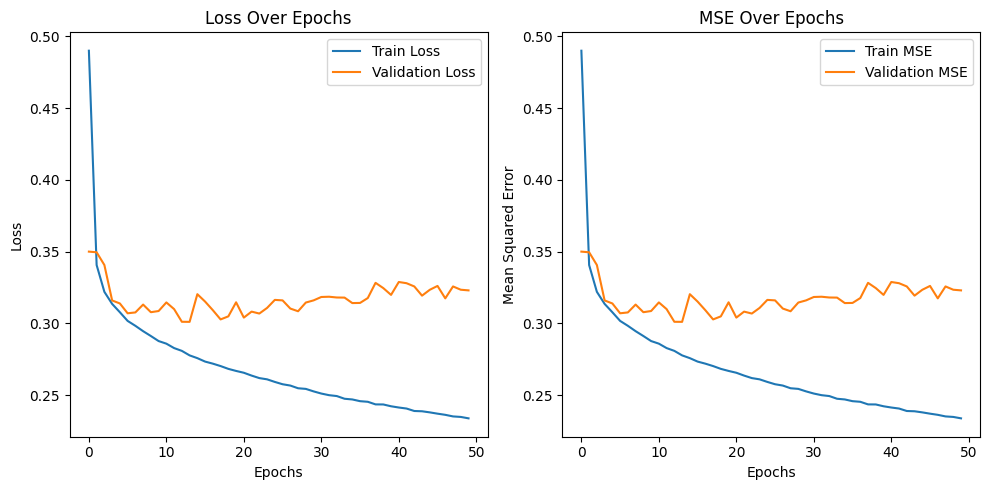

In [56]:
# Plot training history
if 'history' in locals():
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['mean_squared_error'], label='Train MSE')
    plt.plot(history.history['val_mean_squared_error'], label='Validation MSE')
    plt.title('MSE Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error')
    plt.legend()

    plt.tight_layout()
    plt.show()

## Advanced Model Definition
In this section, we create a comprehensive neural network that processes different feature types and their interactions, particularly focusing on the systematic effect of game length on performance metrics before making predictions.

In [57]:
# Input layers
input_length = keras.layers.Input(shape=(1,), name='input_length')  # Game length feature
input_perf = keras.layers.Input(shape=(X_train.shape[1]-1,), name='input_performance')  # Performance features

# Subnetwork for game length
length_network = keras.layers.Dense(16, activation='relu')(input_length)
length_network = keras.layers.BatchNormalization()(length_network)
length_network = keras.layers.Dropout(0.2)(length_network)

# Subnetwork for performance features
perf_network = keras.layers.Dense(128, activation='relu')(input_perf)
perf_network = keras.layers.BatchNormalization()(perf_network)
perf_network = keras.layers.Dropout(0.2)(perf_network)

# Combine both subnetworks
combined = keras.layers.Concatenate()([length_network, perf_network])

# More layers after combining
combined = keras.layers.Dense(64, activation='relu')(combined)
combined = keras.layers.BatchNormalization()(combined)
combined = keras.layers.Dropout(0.3)(combined)
combined = keras.layers.Dense(32, activation='relu')(combined)
output = keras.layers.Dense(1)(combined)

# Build the model
model = keras.models. Model(inputs=[input_length, input_perf], outputs=output)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error', 'mean_absolute_error'])

# Model summary
model.summary()


Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_length        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_performance   │ (None, 210)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 16)        │         32 │ input_length[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 128)       │     27,008 │ input_performanc… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16)        │         64 │ dense_27[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_28[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 16)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 144)       │          0 │ dropout_3[0][0],  │
│ (Concatenate)       │                   │            │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_29 (Dense)    │ (None, 64)        │      9,280 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_29[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 32)        │      2,080 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_31 (Dense)    │ (None, 1)         │         33 │ dense_30[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 39,265 (153.38 KB)

 Trainable params: 38,849 (151.75 KB)

 Non-trainable params: 416 (1.62 KB)

## Training the Advanced Model
Here, we train our advanced model using both the game length and performance features.

In [58]:
# Prepare separate inputs for training based on preprocessed features
train_inputs = {
    'input_length': X_train[:, 0],  # Assuming length is the first column after preprocessing
    'input_performance': X_train[:, 1:]
}

enhanced_model = '../outputs/nn/advanced_model.h5'

# Check if the pre-trained model exists
if os.path.exists(enhanced_model):
    model = keras.models.load_model(enhanced_model)
    print("Loaded pre-trained model.")
else:
    # Fit the model
    history = model.fit(train_inputs, y_train, validation_split=0.2, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
4088/4088 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 2.4342 - mean_absolute_error: 1.0831 - mean_squared_error: 2.4342 - val_loss: 0.4664 - val_mean_absolute_error: 0.5409 - val_mean_squared_error: 0.4664
Epoch 2/50
4088/4088 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.6520 - mean_absolute_error: 0.6312 - mean_squared_error: 0.6520 - val_loss: 0.4516 - val_mean_absolute_error: 0.5262 - val_mean_squared_error: 0.4516
Epoch 3/50
4088/4088 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.5231 - mean_absolute_error: 0.5665 - mean_squared_error: 0.5231 - val_loss: 0.3557 - val_mean_absolute_error: 0.4679 - val_mean_squared_error: 0.3557
Epoch 4/50
4088/4088 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.4562 - mean_absolute_error: 0.5313 - mean_squared_error: 0.4562 - val_loss: 0.3778 - val_mean_absolute_error: 0.4825 - val_mean_squared_error: 0.3778
Epoch 5/50
4088/4088 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.4310 - mean_absolute_error: 0.5166 - mean_squared_error: 0.4310 - val_loss: 0.33

## Evaluating the Advanced Model
We now evaluate how well our comprehensive model performs on the unseen test data.

In [59]:
# Prepare separate inputs for testing
test_inputs = {
    'input_length': X_test[:, 0],
    'input_performance': X_test[:, 1:]
}

# Evaluate the model
test_results = model.evaluate(test_inputs, y_test, verbose=1)

1278/1278 ━━━━━━━━━━━━━━━━━━━━ 1s 707us/step - loss: 0.3145 - mean_absolute_error: 0.4412 - mean_squared_error: 0.3145


## Performance Metrics and Report
Here we calculate detailed metrics and visualize the training process to evaluate the model's effectiveness over time.

In [60]:
# Making predictions using the test inputs prepared earlier
test_predictions = model.predict(test_inputs)

mse = mean_squared_error(y_test, test_predictions)
r2 = r2_score(y_test, test_predictions)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R^2 Score: {r2}")

1278/1278 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Mean Squared Error (MSE): 0.31556324411849307
R^2 Score: 0.9350753923611995


## Saving the Enhanced Model
The model is saved along with its configuration and weights for future use or deployment.

In [61]:
# Save the model
model_path = os.path.join(output_dir, 'advanced_model.h5')
model.save(model_path)
print(f"Model saved to {model_path}")

Model saved to ../outputs/nn\advanced_model.h5


## Model Report
Generate a detailed report including training history to analyze the model's learning process over epochs.

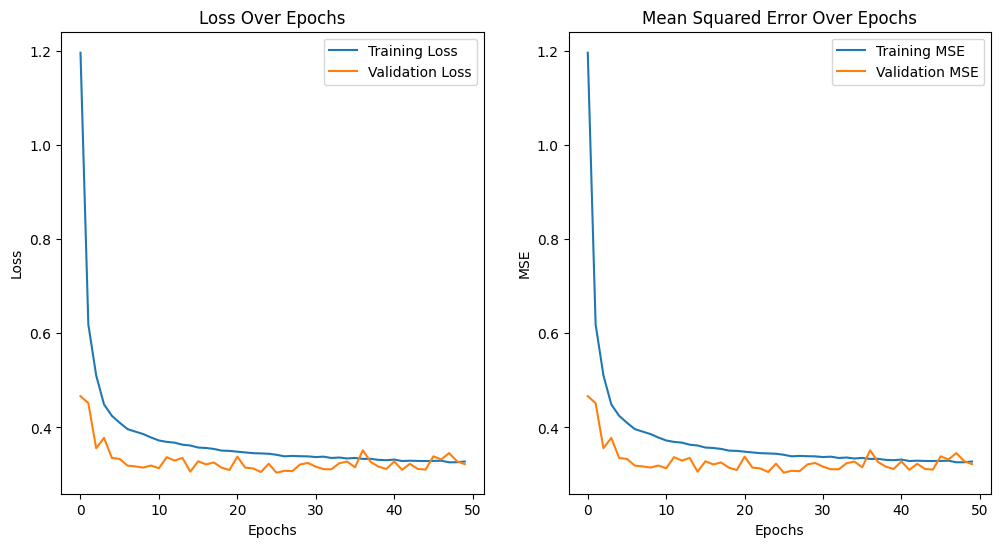

In [62]:
if 'history' in locals():
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['mean_squared_error'], label='Training MSE')
    plt.plot(history.history['val_mean_squared_error'], label='Validation MSE')
    plt.title('Mean Squared Error Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.legend()

    plt.show()